In [20]:
import tensorflow as tf
import yaml
import os
import matplotlib.pyplot as plt

with open('C:/Users/ouaha/OneDrive/Bureau/projet app stat/archive/config.yml', 'r') as file:
    params = yaml.safe_load(file)

preprocessing_params = params['preprocessing']
target_size = tuple(preprocessing_params['target_size'])
normalize = preprocessing_params['normalize']
standardize = preprocessing_params['standardize']


def parse_tfrecord(example_proto):
    # Définir le format de parsing
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_jpeg(parsed_example['image'])
    image = tf.image.resize(image, target_size)  # Redimensionner si nécessaire
    label = parsed_example['label']
    return image, label

def load_tfrecord(filename):
    raw_dataset = tf.data.TFRecordDataset(filename)  # Charger le dataset
    parsed_dataset = raw_dataset.map(parse_tfrecord)  # Parser les données
    return parsed_dataset

# Charger les datasets
train_dataset = load_tfrecord('train_data.tfrecord')
val_dataset = load_tfrecord('val_data.tfrecord')
test_dataset = load_tfrecord('test_data.tfrecord')

Images du dataset d'entraînement:


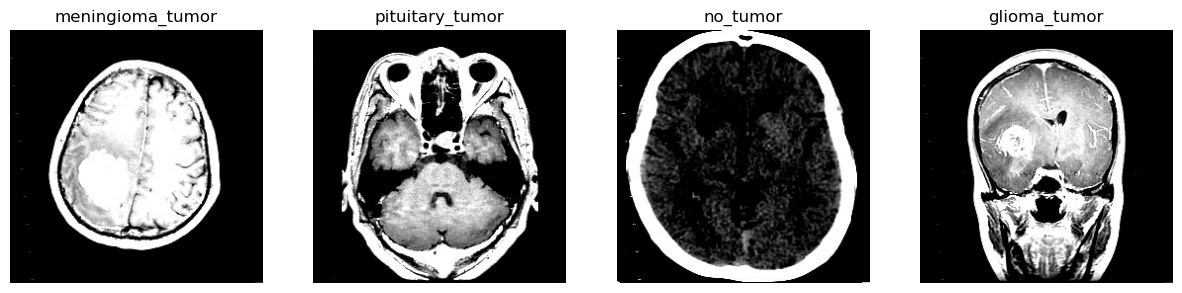

Images du dataset de validation:


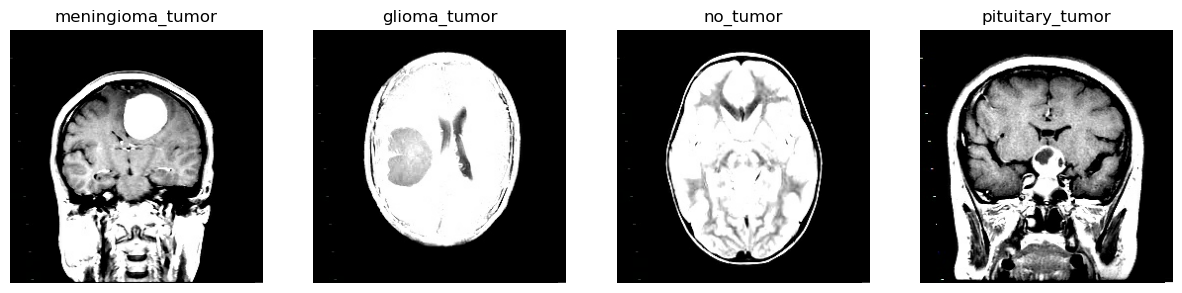

Images du dataset de test:


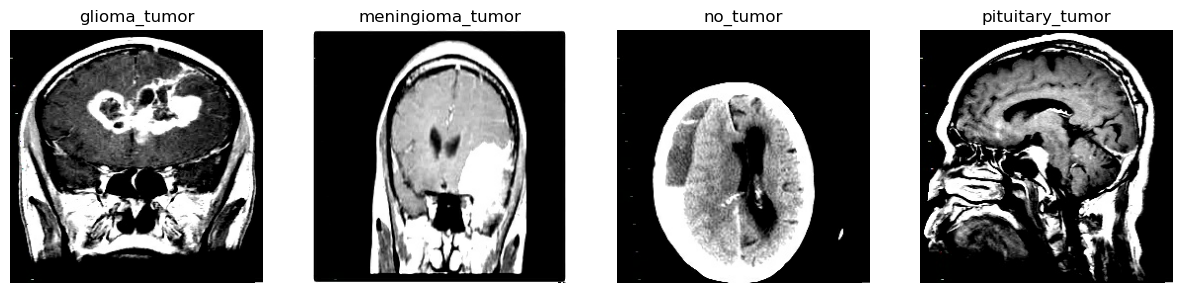

In [21]:
import matplotlib.pyplot as plt
import tensorflow as tf

def display_images_from_dataset_in_line(dataset):
    # Créer un ensemble de labels uniques
    labels_seen = set()
    images = []
    labels = []
    
    # Itérer sur le dataset pour collecter une image par label
    for image, label in dataset:
        label_decoded = label.numpy().decode('utf-8')

        # Si le label n'a pas été vu, ajouter l'image à la liste
        if label_decoded not in labels_seen:
            images.append(image.numpy().astype("uint8"))  # Convertir en uint8
            labels.append(label_decoded)  # Ajouter le label à la liste
            labels_seen.add(label_decoded)  # Marquer le label comme vu

    # Afficher toutes les images en ligne
    plt.figure(figsize=(15, 5))  # Ajustez la taille selon vos besoins
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)  # Créer un subplot pour chaque image
        plt.imshow(images[i])
        plt.title(labels[i])  # Afficher le label comme titre
        plt.axis("off")  # Ne pas afficher les axes
    plt.show()

# Charger vos datasets

# Afficher des images pour chaque label dans le dataset d'entraînement
print("Images du dataset d'entraînement:")
display_images_from_dataset_in_line(train_dataset)
print("Images du dataset de validation:")
display_images_from_dataset_in_line(val_dataset)
print("Images du dataset de test:")
display_images_from_dataset_in_line(test_dataset)



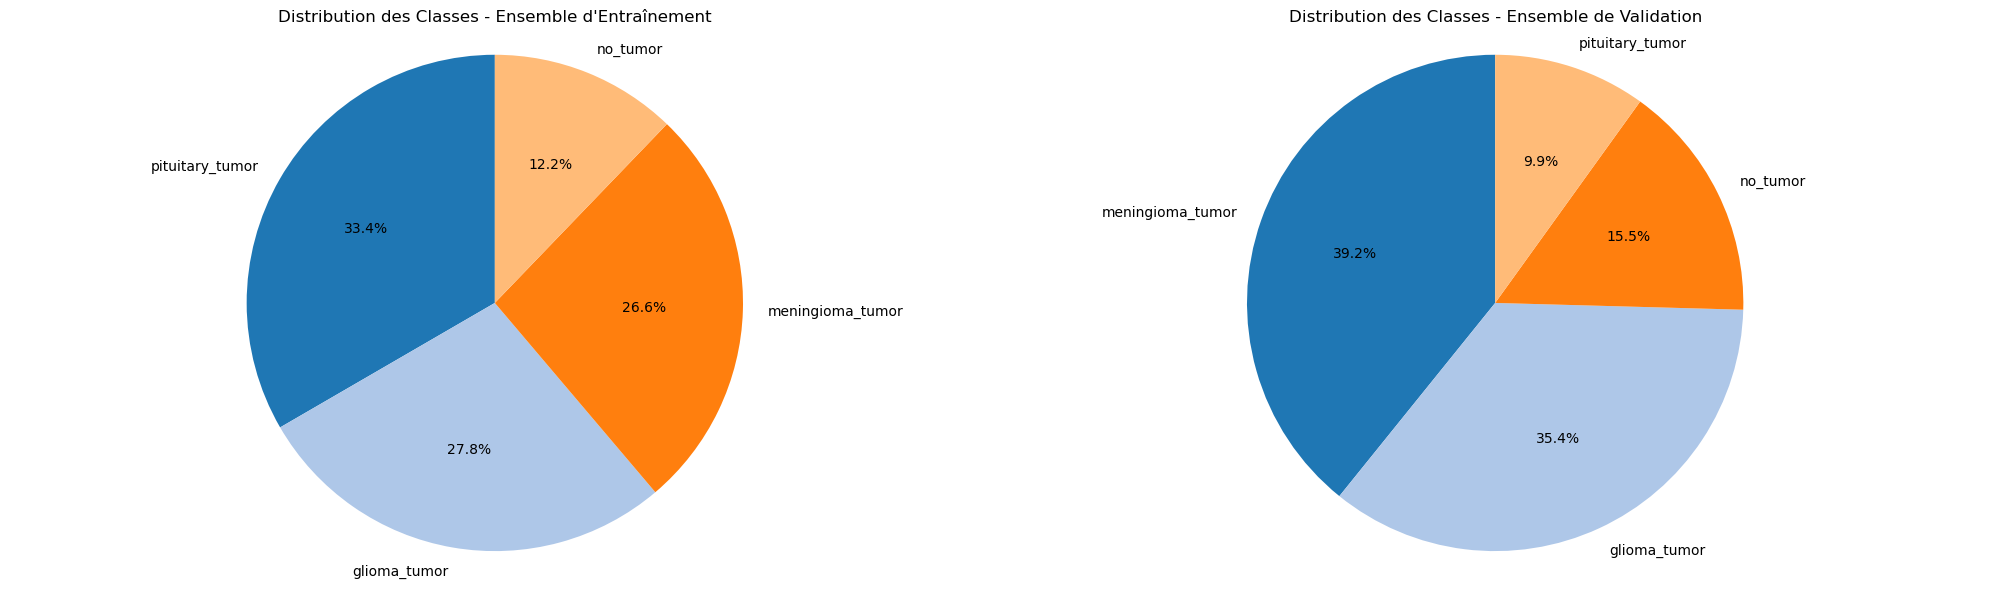

In [22]:
import pandas as pd
import numpy as np

def plot_class_distribution(dataset, title, ax):
    labels = []

    # Collecter les labels du dataset
    for _, label in dataset:
        labels.append(label.numpy().decode('utf-8'))  # Décoder en chaîne de caractères

    # Compter les occurrences de chaque label
    class_counts = pd.Series(labels).value_counts()

    # Créer un camembert
    wedges, texts, autotexts = ax.pie(class_counts, labels=class_counts.index, 
                                       autopct='%1.1f%%', startangle=90,
                                       colors=plt.cm.tab20.colors)  # Utiliser une palette de couleurs
    
    ax.set_title(title)
    ax.axis('equal')  # Pour que le camembert soit un cercle



fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # 3 pie charts en ligne

# Afficher la distribution des classes pour chaque dataset
plot_class_distribution(train_dataset, "Distribution des Classes - Ensemble d'Entraînement", axs[0])
plot_class_distribution(val_dataset, "Distribution des Classes - Ensemble de Validation", axs[1])

# Afficher la figure
plt.tight_layout()
plt.show()

In [23]:
4. Augmentation des Données / Methode des poids / Hyperparametre (learning rate batch tester les plus utiles ici) 


SyntaxError: invalid syntax (479764004.py, line 1)

In [12]:
import numpy as np
from collections import defaultdict

def calculate_mean_std_per_class(dataset):
    class_pixel_sums = defaultdict(float)
    class_pixel_counts = defaultdict(int)
    class_pixel_squared_sums = defaultdict(float)
    
    # Parcourir le dataset
    for img, label in dataset:
        # Convertir l'image en numpy si nécessaire
        if not isinstance(img, np.ndarray):
            img = img.numpy()
        
        # Décoder le label en chaîne de caractères
        label = label.numpy().decode('utf-8') if hasattr(label, 'numpy') else label
        
        # Applatir l'image en une seule dimension pour traiter tous les pixels
        flattened_img = img.flatten()
        
        # Mettre à jour les statistiques pour la classe
        class_pixel_sums[label] += flattened_img.sum()
        class_pixel_counts[label] += flattened_img.size
        class_pixel_squared_sums[label] += np.square(flattened_img).sum()
    
    # Calcul de la moyenne et de l'écart-type par classe
    class_stats = {}
    for label in class_pixel_sums.keys():
        # Moyenne
        mean = class_pixel_sums[label] / class_pixel_counts[label]
        
        # Écart-type
        mean_square = class_pixel_squared_sums[label] / class_pixel_counts[label]
        std_dev = np.sqrt(mean_square - mean**2)
        
        # Stockage des résultats
        class_stats[label] = {"moyenne": mean, "écart-type": std_dev}
    
    return class_stats

# Utilisation de la fonction
print('train set')
stats = calculate_mean_std_per_class(train_dataset)
for label, values in stats.items():
    print(f"Classe {label} - Moyenne : {values['moyenne']:.2f}, Écart-Type : {values['écart-type']:.2f}")

print('Validation set')
stats = calculate_mean_std_per_class(val_dataset)
for label, values in stats.items():
    print(f"Classe {label} - Moyenne : {values['moyenne']:.2f}, Écart-Type : {values['écart-type']:.2f}")
    
print('test set')
stats = calculate_mean_std_per_class(test_dataset)
for label, values in stats.items():
    print(f"Classe {label} - Moyenne : {values['moyenne']:.2f}, Écart-Type : {values['écart-type']:.2f}")


train set
Classe meningioma_tumor - Moyenne : 77.93, Écart-Type : 103.23
Classe pituitary_tumor - Moyenne : 79.99, Écart-Type : 96.80
Classe no_tumor - Moyenne : 78.29, Écart-Type : 102.85
Classe glioma_tumor - Moyenne : 79.38, Écart-Type : 103.90
Validation set
Classe meningioma_tumor - Moyenne : 78.48, Écart-Type : 103.46
Classe glioma_tumor - Moyenne : 79.27, Écart-Type : 103.70
Classe no_tumor - Moyenne : 79.79, Écart-Type : 103.64
Classe pituitary_tumor - Moyenne : 80.55, Écart-Type : 95.80
test set
Classe glioma_tumor - Moyenne : 76.53, Écart-Type : 98.91
Classe meningioma_tumor - Moyenne : 76.56, Écart-Type : 99.57
Classe no_tumor - Moyenne : 78.48, Écart-Type : 104.41
Classe pituitary_tumor - Moyenne : 73.54, Écart-Type : 97.42


In [28]:
### Moyennes similaires différences d’intensité moyenne ne suffiront  pas pour distinguer les classes.  utiliser des méthodes qui capturent 
#la structure spatiale et les motifs dans les images pour faire la classification

## Variance trés grande bonne chose image trés contrastée mais peut poser probléme pour l'apprentissage 
#faire une normalisation et tandardisation pour aider l'algorithme à mieux converger 


In [13]:
import numpy as np
import tensorflow as tf

def calculate_variance_intra(dataset):
    class_means = {}
    class_variances = {}
    total_means = []

    # Parcourir le dataset et regrouper les images par classe pour calculer les statistiques
    for image, label in dataset:
        label = label.numpy().decode('utf-8')  # Décoder le label en chaîne de caractères
        image = image.numpy().flatten()  # Aplatir l'image pour obtenir un vecteur

        # Calculer la moyenne et la variance pour chaque classe
        if label not in class_means:
            class_means[label] = []
            class_variances[label] = []
        class_means[label].append(image.mean())
        class_variances[label].append(image.var())

    # Calcul des variances intra-classe
    intra_class_variances = {label: np.mean(class_variances[label]) for label in class_variances}

    return intra_class_variances

# Utilisation de la fonction
intra_class_variances= calculate_variance_intra(train_dataset)
print("Variance intra-classe par classe :", intra_class_variances)


Variance intra-classe par classe : {'meningioma_tumor': 10599.015, 'pituitary_tumor': 9339.257, 'no_tumor': 10425.805, 'glioma_tumor': 10763.358}
